## Решающие деревья


In [4]:
%pylab inline
import numpy as np
import pandas as pd
import pylab as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
sns.set(style='whitegrid')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<img src="https://hsto.org/r/w1560/files/401/8cd/bea/4018cdbea7a64306be94ed784fce4a06.png">

<img src="https://hsto.org/files/194/9b6/ae9/1949b6ae97ab4fc9b1a37fbf182eda8f.gif">

***Две важные формулы:***

1. Энтропия: $S = -\sum_{i=1}^N p_i \log_2 p_i$ ($N$ -- количество целевых признаков, $p_i$ -- априорная вероятность того, что объект принадлежит $i$-му классу). Энтропия соответствует степени хаоса в системе.

2. Прирост информации: пусть дана энтропия $S_0$ и некоторое множество "новых" значений энтропии $S_1, ..., S_q$ после преобразования информации (в нашем случае, после разбиения дерева), тогда $I(Q) = S_0 - \sum_{i=1}^q \frac{N_i}{N} S_i$ является значением прироста информации признака $Q$, где $N_i$ -- число элементов, которые принимают $i$-е значение на признаке $Q$.

**Построение дерева:**

Пример:

Пусть дан 1 признак $x$, 20 объектов и ещё один "целевой" признак (выделено желтым и синим цветом). Например, пусть задача звучит так: "Дано 20 шаров синего или желтого цвета, определить их цвет по диаметру шара, равному $x$".

Будем предсказывать цвет шарика по его координате. Конечно, ничего общего с жизнью это не имеет, но позволяет показать, как энтропия используется для построения дерева решений.

<img src="https://hsto.org/r/w1560/files/c96/80a/a4b/c9680aa4babc40f4bbc8b3595e203979.png">

Здесь 9 синих шариков и 11 желтых. Если мы наудачу вытащили шарик, то он с вероятностью $p_1=\frac{9}{20}$ будет синим и с вероятностью $p_2=\frac{11}{20}$ – желтым. Значит, энтропия состояния $S_0 = -\frac{9}{20}\log_2{\frac{9}{20}}-\frac{11}{20}\log_2{\frac{11}{20}} \approx 1$. Само это значение пока ни о чем нам не говорит. Теперь посмотрим, как изменится энтропия, если разбить шарики на две группы – с координатой меньше либо равной 12 и больше 12.

<img src="https://hsto.org/r/w1560/files/186/444/a8b/186444a8bd0e451c8324ca8529f8d4f4.png">

В левой группе оказалось 13 шаров, из которых 8 синих и 5 желтых. Энтропия этой группы равна $S_1 = -\frac{5}{13}\log_2{\frac{5}{13}}-\frac{8}{13}\log_2{\frac{8}{13}} \approx 0.96$. В правой группе оказалось 7 шаров, из которых 1 синий и 6 желтых. Энтропия правой группы равна $S_2 = -\frac{1}{7}\log_2{\frac{1}{7}}-\frac{6}{7}\log_2{\frac{6}{7}} \approx 0.6$. Как видим, энтропия уменьшилась в обеих группах по сравнению с начальным состоянием, хоть в левой и не сильно.
После разделения получилось две группы ($q = 2$) – одна из 13 элементов ($N_1 = 13$), вторая – из 7 ($N_2 = 7$). Прирост информации равен
$I(x \leq 12) = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16.$

Получается, разделив шарики на две группы по признаку "координата меньше либо равна 12", мы уже получили более упорядоченную систему, чем в начале. Продолжим деление шариков на группы до тех пор, пока в каждой группе шарики не будут одного цвета.

<img src="https://hsto.org/r/w1560/files/dae/a88/2b0/daea882b0a8e4ef4b23325c88f0353a1.png">

Для правой группы потребовалось всего одно дополнительное разбиение по признаку "координата меньше либо равна 18", для левой – еще три. Очевидно, энтропия группы с шариками одного цвета равна 0 ($\log_2{1} = 0$), что соответствует представлению, что группа шариков одного цвета – упорядоченная.
В итоге мы построили дерево решений, предсказывающее цвет шарика по его координате. Отметим, что такое дерево решений может плохо работать для новых объектов (определения цвета новых шариков), поскольку оно идеально подстроилось под обучающую выборку (изначальные 20 шариков). Для классификации новых шариков лучше подойдет дерево с меньшим числом "вопросов", или разделений, пусть даже оно и не идеально разбивает по цветам обучающую выборку.

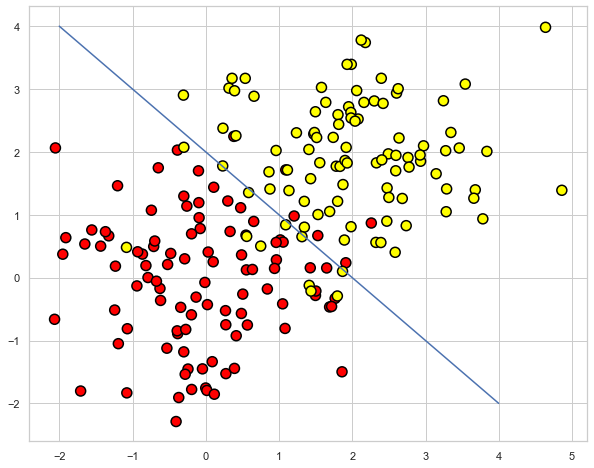

In [13]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

# первый класс
np.random.seed(7)
train_data = np.random.normal(size=(100, 2))
train_labels = np.zeros(100)

# добавляем второй класс
train_data = np.r_[train_data, np.random.normal(size=(100, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(100)]

plt.rcParams['figure.figsize'] = (10,8)
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5)
plt.plot(range(-2,5), range(4,-3,-1))

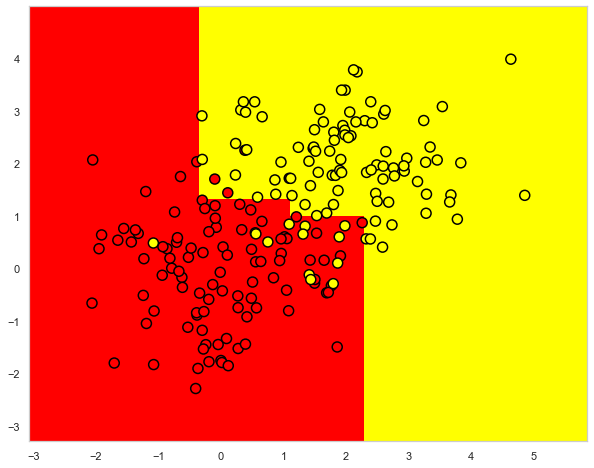

In [10]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=17)

# обучаем дерево
clf_tree.fit(train_data, train_labels)

# немного кода для отображения разделяющей поверхности
xx, yy = get_grid(train_data)
predicted = clf_tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5)

**max_depth** – максимальная глубина дерева;

**max_features** — максимальное число признаков, по которым ищется лучшее разбиение в дереве (это нужно потому, что при большом количестве признаков будет "дорого" искать лучшее (по критерию типа прироста информации) разбиение среди всех признаков);

**min_samples_leaf** – минимальное число объектов в листе. У этого параметра есть понятная интерпретация: скажем, если он равен 5, то дерево будет порождать только те классифицирующие правила, которые верны как минимум для 5 объектов

**Как выглядит дерево в нашем примере?**

<img src="https://hsto.org/files/bf1/1fe/490/bf11fe49088f428996a27b0d2d2a6592.png">

Основные способы борьбы с переобучением в случае деревьев решений:


1. искусственное ограничение глубины или минимального числа объектов в листе: построение дерева просто в какой-то момент прекращается (параметр max_depth);

2. стрижка дерева

Пример переобученного дерева:
<img src="https://hsto.org/r/w1560/files/f9f/3b5/133/f9f3b5133bae460ba96ab7e546155b1d.png">

**Дерево решений в задаче регрессии**

При прогнозировании количественного признака идея построения дерева остается та же, но меняется критерий качества:


Дисперсия вокруг среднего: $ D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{i =1}^{\ell} y_i)^2, $
где $\ell$ – число объектов в листе, $y_i$ – значения целевого признака. Попросту говоря, минимизируя дисперсию вокруг среднего, мы ищем признаки, разбивающие выборку таким образом, что значения целевого признака в каждом листе примерно равны.

In [4]:
from sklearn.tree import DecisionTreeRegressor

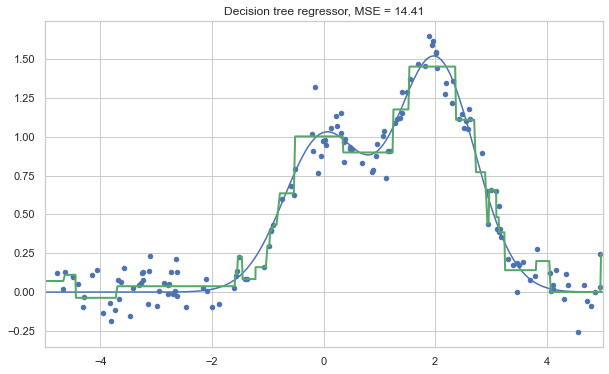

In [26]:
n_train = 150        
n_test = 1000       
noise = 0.1

def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
    np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

from sklearn.tree import DecisionTreeRegressor

reg_tree = DecisionTreeRegressor(max_depth=5, random_state=17)

reg_tree.fit(X_train, y_train)
reg_tree_pred = reg_tree.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, reg_tree_pred, "g", lw=2)
plt.xlim([-5, 5])
plt.title("Decision tree regressor, MSE = %.2f" % np.sum((y_test - reg_tree_pred) ** 2))
plt.show()

## Подбор параметров

Посмотрим на качество дерева в зависимости от параметров на одном из стандартных наборов данных &mdash; Бостонском датасете.

Загрузим датасет и посмотрим на него.

In [29]:
from sklearn.datasets import load_boston

data = load_boston()
X = data.data
y = data.target

Сделаем разбиения для кросс-валидации

In [30]:
from sklearn.model_selection import KFold, cross_val_score
cv = KFold(shuffle=True, random_state=241)

Теперь переберем разные параметры для дерева

In [43]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
gs = GridSearchCV(DecisionTreeRegressor(random_state=241),
                  param_grid={
                      'max_features': ['auto', 'log2'], # the number of features to consider when looking for the best split
                      'max_depth': [2, 4, 6, 8, 10, 20, 50],
                      'min_samples_leaf': [1, 4, 8, 32],
                  },
                  cv=cv,
                  scoring='r2')
gs.fit(X, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=241, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=241),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 20, 50],
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': [1, 4, 8, 32]},
             scoring='r2')

In [44]:
cv_grid = pd.DataFrame(gs.cv_results_['params'])

cv_grid['mean_test_score'] = gs.cv_results_['mean_test_score']

In [45]:
cv_grid.head()

,max_depth,max_features,min_samples_leaf,mean_test_score
0,2,auto,1,0.628959
1,2,auto,4,0.628959
2,2,auto,8,0.628959
3,2,auto,32,0.592873
4,2,log2,1,0.405284


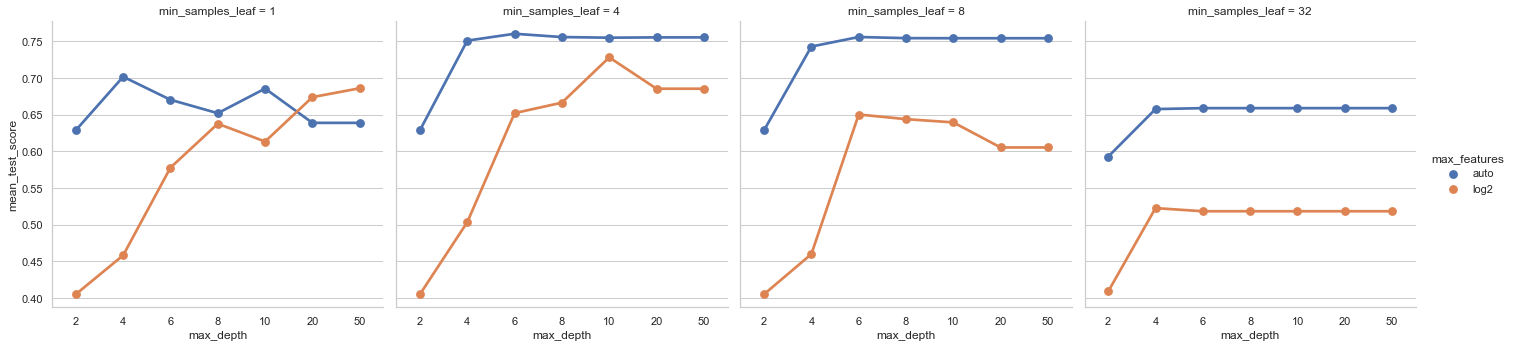

In [46]:
sns.catplot(x='max_depth', y='mean_test_score', data=cv_grid,
            col='min_samples_leaf', hue='max_features',
            kind='point')

* предположите почему при увеличении параметра `min_samples_leaf` дерево перестает переобучаться при росте `max_depth` ?

In [21]:
gs.best_score_

0.7445289638054001

In [22]:
gs.best_params_

{'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 4}

**Плюсы и минусы деревьев решений**

Плюсы:


1. Порождение четких правил классификации, понятных человеку, например, "если возраст < 25 и интерес к мотоциклам, то отказать в кредите". Это свойство называют интерпретируемостью модели;

2. Деревья решений могут легко визуализироваться, то есть может "интерпретироваться" (строгого определения я не видел) как сама модель (дерево), так и прогноз для отдельного взятого тестового объекта (путь в дереве);

3. Быстрые процессы обучения и прогнозирования;

4. Малое число параметров модели;

5. Поддержка и числовых, и категориальных признаков.

Минусы:


1. У порождения четких правил классификации есть и другая сторона: деревья очень чувствительны к шумам во входных данных, вся модель может кардинально измениться, если немного изменится обучающая выборка (например, если убрать один из признаков или добавить несколько объектов);

2. Разделяющая граница, построенная деревом решений, имеет свои ограничения (состоит из гиперплоскостей, перпендикулярных какой-то из координатной оси), и на практике дерево решений по качеству классификации уступает некоторым другим методам;

3. Необходимость отсекать ветви дерева (pruning) или устанавливать минимальное число элементов в листьях дерева или максимальную глубину дерева для борьбы с переобучением;

4. Нестабильность. Небольшие изменения в данных могут существенно изменять построенное дерево решений. С этой проблемой борются с помощью ансамблей деревьев решений;

5. Проблема поиска оптимального дерева решений (минимального по размеру и способного без ошибок классифицировать выборку) NP-полна, поэтому на практике используются эвристики типа жадного поиска признака с максимальным приростом информации, которые не гарантируют нахождения глобально оптимального дерева;

6. Сложно поддерживаются пропуски в данных;